<a href="https://colab.research.google.com/github/sanyakapoor27/BreaKHis-Classification-with-CBAM-Block/blob/main/EfficientNet_Classification_BreaKHis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this colab file, we have built a classification model for Breast Cancer into benign and malignant categories using VGG16 as our classifier.
First, we start by installing tensorflow and importing the necessary packages and libraries.

In [ ]:
!pip install tensorflow

In [ ]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 14.5 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
#importing necessary packages
import os
import tensorflow as tf
import numpy as np
import cv2
from tensorflow import keras
import matplotlib.pyplot as plt
import shutil
import hashlib
from hashlib import md5
import imageio.v2 as imageio
from imageio import imread
import pandas as pd
from keras.utils import img_to_array, array_to_img
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.keras.layers import Layer, Conv2D, BatchNormalization, ReLU, Add

In [ ]:
from tensorflow.keras.applications import EfficientNetB2, EfficientNetB3, EfficientNetV2S
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from keras import backend as K
from keras.activations import sigmoid

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import visualkeras

In [ ]:
#setting gpu memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
#downloading kaggle.json file
!gdown "https://drive.google.com/uc?id=1UvRuiTaifBWLHnueH8z4Bj5gihcaxmiM"

Downloading...
From: https://drive.google.com/uc?id=1UvRuiTaifBWLHnueH8z4Bj5gihcaxmiM
To: /content/kaggle.json
100% 70.0/70.0 [00:00<00:00, 340kB/s]


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
#downloading dataset from kaggle
!kaggle datasets download -d ambarish/breakhis

100% 3.98G/3.99G [03:14<00:00, 26.1MB/s]
100% 3.99G/3.99G [03:14<00:00, 22.0MB/s]


In [ ]:
#unzipping
!unzip breakhis.zip

Streaming output truncated to the last 5000 lines.
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-027.png  
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-028.png  
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-029.png  
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-030.png  
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-031.png  
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-032.png  
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/duct

# Exploratory Data Analysis

In this section, we will explore our image dataset by looking at the different classes we have, the total number of images and finding duplicated images in the dataset.

In [ ]:
def move_images(datadir, dest):
  for classes in os.listdir(datadir):
    for folder in os.listdir(os.path.join(datadir, classes)):
      for zoom in os.listdir(os.path.join(datadir, classes, folder)):
        for img in os.listdir(os.path.join(datadir, classes, folder, zoom)):
          source = (os.path.join(datadir,classes,folder,zoom,img))

          shutil.move(source,dest)

In [ ]:
os.remove('/content/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/README.txt')

In [ ]:
os.remove('/content/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/count_files.sh')

In [ ]:
data_dir = '/content/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB'

In [ ]:
data_dir2 = '/content/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB'

In [ ]:
%mkdir Cancer Cancer/malignant Cancer/benign

In [ ]:
move_images(data_dir, os.path.join('Cancer', 'benign'))
move_images(data_dir2, os.path.join('Cancer', 'malignant'))

In [ ]:
malignant_dir = "./Cancer/malignant"
benign_dir = "./Cancer/benign"
data_dir = "./Cancer"

In [ ]:
os.chdir("/content/")

# Pre-processing

Here, we resize the images and save the as numpy arrays.

In [ ]:
path = "/content/Cancer/benign/SOB_B_A-14-22549AB-100-001.png"
image = cv2.imread(path)
image = cv2.resize(image, (224, 224))

l = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
lab[:,:,0] = clahe.apply(lab[:,:,0])
lab = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

fltr_img = cv2.GaussianBlur(lab, (3,3), 0)

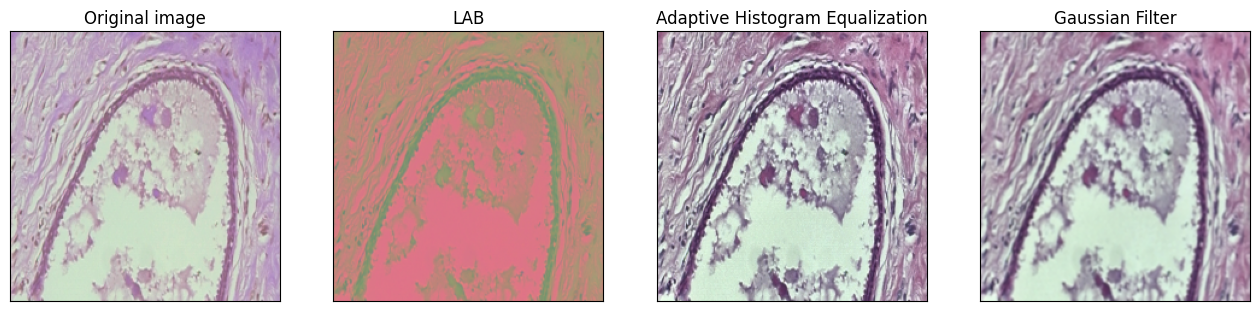

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(141)
plt.imshow(image, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title('Original image')
plt.subplot(142)
plt.imshow(l, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title('LAB')
plt.subplot(143)
plt.imshow(lab, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title('Adaptive Histogram Equalization')
plt.subplot(144)
plt.imshow(fltr_img, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title('Gaussian Filter')

plt.show()

In [ ]:
def preprocessing(dir_name):

  labels = {}
  preprocessed_labels = []
  preprocessed_image = []
  i = 0

  for image_class in os.listdir(dir_name):
    labels[i] = image_class
    for img in os.listdir(os.path.join(dir_name, image_class)):
      path = os.path.join(dir_name, image_class, img)

      image = cv2.imread(path)
      image = cv2.resize(image, (224, 224))

      lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

      clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
      lab[:,:,0] = clahe.apply(lab[:,:,0])
      lab = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

      fltr_img = cv2.GaussianBlur(lab, (5,5), 0)

      preprocessed_image.append(fltr_img)
      preprocessed_labels.append(i)

    i+=1

  preprocessed_image = np.array(preprocessed_image)
  preprocessed_labels = np.array(preprocessed_labels)
  print("Preprocessing is complete!")
  return preprocessed_image, preprocessed_labels, labels

In [ ]:
#applying the preprocessing function on our data directory and then saving them
X, Y, labels = preprocessing(data_dir)

Preprocessing is complete!


In [ ]:
labels

{0: 'benign', 1: 'malignant'}

# Train-Test Split

We've split the data into a ratio of 80:20 for training and testing respectively. Separate folders for train and test are created and images are divided following the above mentioned ratio.

In [ ]:
#splitting our preprocessed images in 80:20 for training and testing respectively
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [ ]:
#splitting our preprocessed images in 80:20 for training and testing respectively
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [ ]:
%mkdir train test val train/benign train/malignant test/benign test/malignant val/benign val/malignant

In [ ]:
train_dir = "/content/train"
test_dir = "/content/test"
val_dir = "./val"

In [ ]:
#function to save images to directory

def save_images(x_set, y_set, dir):
  i = 0
  for (img, imgclass) in zip(x_set, y_set):
    if imgclass == 0:
      cv2.imwrite(os.path.join(dir, 'benign', str(i) + '.jpg' ), img)
    else:
      cv2.imwrite(os.path.join(dir, 'malignant', str(i) + '.jpg'), img)
    i+=1
  print("Images successfully saved!")

In [ ]:
save_images(x_train, y_train, train_dir)
save_images(x_test, y_test, test_dir)
save_images(x_val, y_val, val_dir)

Images successfully saved!
Images successfully saved!
Images successfully saved!


# Data Augmentation

Data Augmentation helps us to diversify the data we feed the training model. We've used the ImageDataGenerator class from Keras for our training directory and applied the following augmentations to our training data such as rotation, flipping, width shift etc.

In [ ]:
#listing the augmentations to be applied to training images using ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale = 1./255,
    fill_mode="reflect",
    brightness_range=[0.3, 0.2],
    horizontal_flip=True,
    vertical_flip=True,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    color_mode='rgb',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle =True,
    seed=42,
)

Found 6406 images belonging to 2 classes.


In [ ]:
#listing the augmentations to be applied to training images using ImageDataGenerator
val_datagen = ImageDataGenerator(
    rescale = 1./255,
)

val_generator = train_datagen.flow_from_directory(
    val_dir,
    color_mode='rgb',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle =True,
    seed=42,
)

Found 712 images belonging to 2 classes.


In [ ]:
#using ImageDataGenerator class for test images (only rescaling)
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = train_datagen.flow_from_directory(
    test_dir,
    color_mode='rgb',
    target_size=(224, 224),
    batch_size=1,
    class_mode=None,
    shuffle =False,
    seed=42,
)

Found 791 images belonging to 2 classes.


In [ ]:
#for visualizing
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.2, 0.3],
    horizontal_flip=True,
    fill_mode="reflect",
    vertical_flip=True,
)

In [ ]:
os.mkdir('preview')

In [ ]:
#for visualizing
x_demo = x_train[0]
x_demo = np.array(x_demo).reshape(1,224, 224, 3)

i = 0
for batch in demo_datagen.flow(x_demo, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='png'):
    i += 1
    if i > 20:
        break

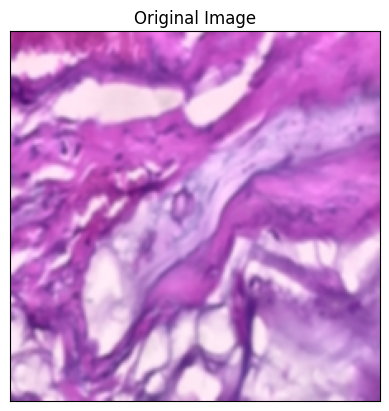

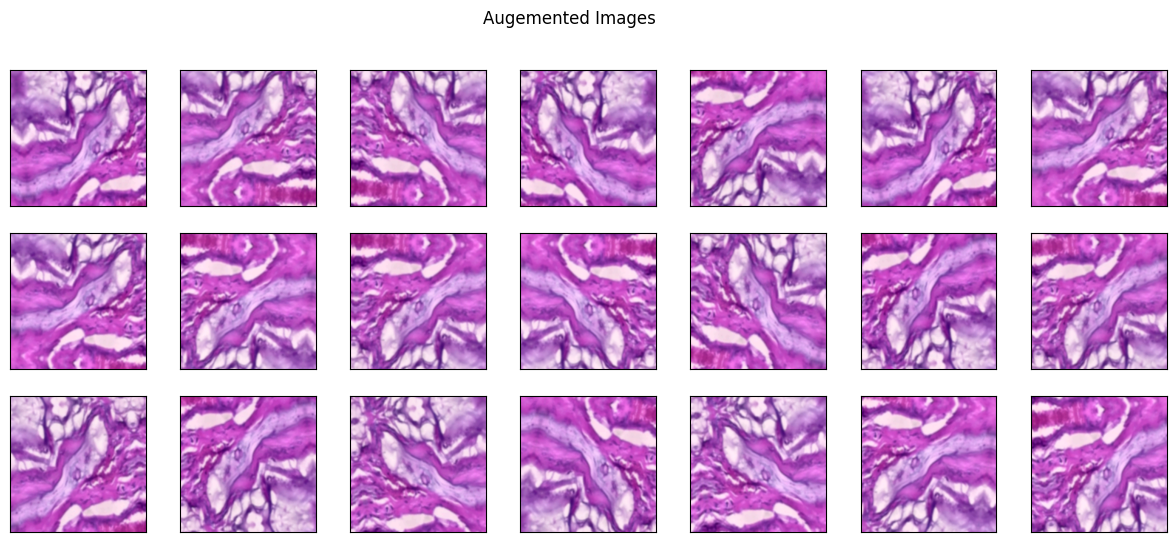

In [ ]:
#showing the orignal and augmented images
plt.imshow(x_train[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# EfficientNet Attention

In [ ]:
def cbam_block(cbam_feature, ratio=8):
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature

In [ ]:
def channel_attention(input_feature, ratio=8):

	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]

	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')

	avg_pool = GlobalAveragePooling2D()(input_feature)
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)

	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool.shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)

	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('sigmoid')(cbam_feature)

	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)

	return multiply([input_feature, cbam_feature])

In [ ]:
def spatial_attention(input_feature):
	kernel_size = 7

	if K.image_data_format() == "channels_first":
		channel = input_feature.shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature.shape[-1]
		cbam_feature = input_feature

	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool.shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool.shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat.shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)
	assert cbam_feature.shape[-1] == 1

	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)

	return multiply([input_feature, cbam_feature])

In [ ]:
# Load the pre-trained EfficientNetB0 model
base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Apply the channel attention mechanism
# Apply the spatial attention mechanism
dual_attention_output = cbam_block(base_model.output)

# Combine both channel and spatial attentions
combined_attention = tf.keras.layers.Add()([dual_attention_output])

# For example, flatten, add dense layers, and output layers for your specific task
x = GlobalAveragePooling2D()(combined_attention)
#x = Dense(1024, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(max_value=2.0, axis=0))(x)
x = Dropout(0.6)(x)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
#x = Dropout(0.6)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x) # Adjust num_classes as per your task

# Freeze the layers of the base EfficientNetB0 model for transfer learning
base_model.trainable = False

for layers in base_model.layers:
  if "BatchNormalization" in layers.__class__.__name__:
    layers.trainable= True

# Create the final model
model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

82420632/82420632 [==============================] - 4s 0us/step


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.636846 to fit



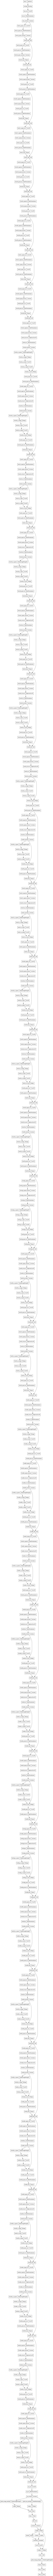

In [ ]:
tf.keras.utils.plot_model(model, "model.png")

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 24)         648       ['rescaling[0][0]']           
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 24)         96        ['stem_conv[0][0]']           
 n)                                                                                           

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
eff_att_train = model.fit(train_generator, epochs=80, validation_data=val_generator, callbacks=[early_stopping])

Epoch 1/80
201/201 [==============================] - 201s 669ms/step - loss: 1.4470 - accuracy: 0.6826 - val_loss: 1.1267 - val_accuracy: 0.7865
Epoch 2/80
201/201 [==============================] - 132s 658ms/step - loss: 1.0146 - accuracy: 0.7456 - val_loss: 0.8497 - val_accuracy: 0.8244
Epoch 3/80
201/201 [==============================] - 131s 649ms/step - loss: 0.8292 - accuracy: 0.7726 - val_loss: 0.7161 - val_accuracy: 0.8371
Epoch 4/80
201/201 [==============================] - 132s 655ms/step - loss: 0.7313 - accuracy: 0.7872 - val_loss: 0.6239 - val_accuracy: 0.8511
Epoch 5/80
201/201 [==============================] - 132s 658ms/step - loss: 0.6639 - accuracy: 0.8050 - val_loss: 0.5723 - val_accuracy: 0.8624
Epoch 6/80
201/201 [==============================] - 132s 654ms/step - loss: 0.6166 - accuracy: 0.8110 - val_loss: 0.5244 - val_accuracy: 0.8652
Epoch 7/80
201/201 [==============================] - 130s 647ms/step - loss: 0.5797 - accuracy: 0.8183 - val_loss: 0.4806 -

In [ ]:
#predicting
predictions_eff_at = model.predict(test_generator)

791/791 [==============================] - 23s 24ms/step


In [ ]:
effatt_pred_classes = np.round(predictions_eff_at).astype("int32")
effatt_cf = classification_report(test_labels, effatt_pred_classes)
print(effatt_cf)

              precision    recall  f1-score   support

           0       0.87      0.86      0.86       243
           1       0.94      0.95      0.94       548

    accuracy                           0.92       791
   macro avg       0.91      0.90      0.90       791
weighted avg       0.92      0.92      0.92       791



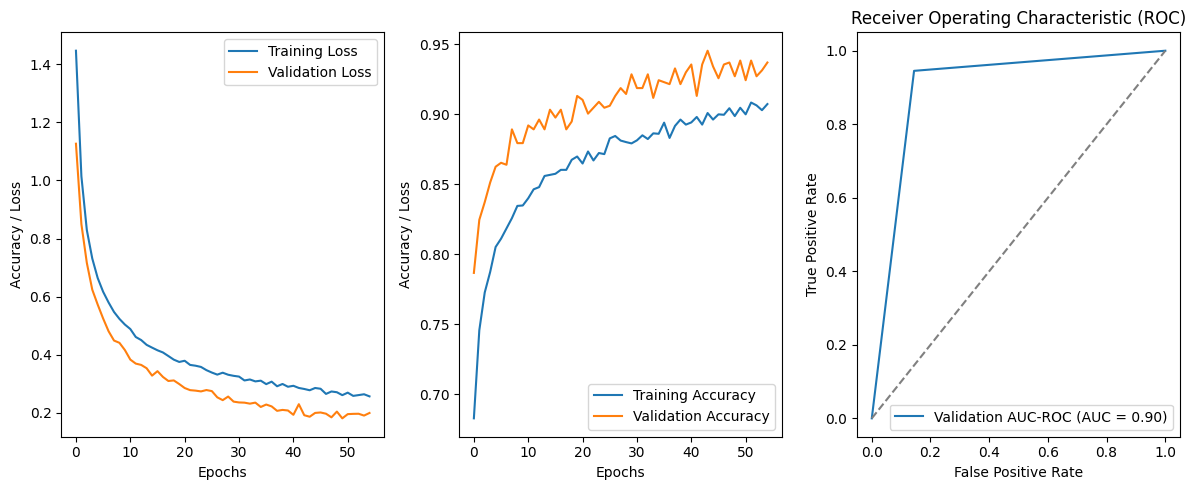

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(eff_att_train.history['loss'], label='Training Loss')
plt.plot(eff_att_train.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(eff_att_train.history['accuracy'], label='Training Accuracy')
plt.plot(eff_att_train.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend()

# Calculate AUC-ROC
fpr, tpr, thresholds = roc_curve(test_labels, effatt_pred_classes)
roc_auc = roc_auc_score(test_labels, effatt_pred_classes)

# Plot AUC-ROC
plt.subplot(1, 3, 3)
plt.plot(fpr, tpr, label=f'Validation AUC-ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()

plt.tight_layout()
plt.show()